# What the strategy does (end-to-end)

## 1) Build a **Daily bias** (higher-timeframe context)

* We aggregate your intraday bars into **daily OHLC**.
* Using confirmed **pivots** (left=`D_L`, right=`D_R`), we detect **BOS** (break of structure):

  * **Bullish bias** (+1) if today’s **daily close > last confirmed daily swing high**.
  * **Bearish bias** (–1) if today’s **daily close < last confirmed daily swing low**.
* We also compute the daily **equilibrium (EQ)** = 50% between the last confirmed daily swing high/low.
* **No look-ahead:** on each intraday bar, we only use the **bias/equilibrium as of the previous day**. (See `build_daily_bias(...)` and how `prev_idx` is chosen.)

## 2) Only trade **in your session windows**

* By default (NSE example): 09:20–10:45 and 13:45–15:10 local time.
* **New signals** are allowed only in session; **risk management** (stops/targets) runs on all bars (so stops can hit even if you’re outside the window).

## 3) Wait for a **liquidity sweep** on intraday

* We compute intraday pivots (`I_L`, `I_R`) to define the **last confirmed swing**.
* **Long setup:** a **sell-side sweep** = current bar’s **low < last swing low** and **closes back above** that swing low.
* **Short setup:** a **buy-side sweep** = current bar’s **high > last swing high** and **closes back below** that swing high.

## 4) Require **displacement** + **Fair Value Gap (FVG)**

* **3-bar FVG** definition:

  * **Bullish:** bar\[i-2].high < bar\[i].low
  * **Bearish:** bar\[i-2].low  > bar\[i].high
* **Displacement filter:** current candle body ≥ `DISPLACEMENT_FACTOR` × **median body of last 10 bars** (default 1.2×).
  This avoids weak moves that don’t really “push” price.

## 5) **Entry** = 50% of the fresh FVG, but only in the “right half” of the HTF range

* For **longs** (bullish daily bias): price must be in **discount** (close ≤ daily EQ) when the signal prints.
* For **shorts** (bearish daily bias): price must be in **premium** (close ≥ daily EQ).
* We place a **pending limit order at the FVG midpoint** and keep it alive for `PENDING_EXPIRY_BARS` (default 30 bars). If price doesn’t revisit, the order expires (no chase).

## 6) **Stop-loss** and **targets**

* **Stop-loss**: at the relevant **intraday swing** (the one we swept), buffered by **ATR**:

  * Long stop = `min(last_swing_low, FVG_floor) – ATR_PAD × ATR`
  * Short stop = `max(last_swing_high, FVG_ceiling) + ATR_PAD × ATR`
* **Take-profit**:

  1. **Partial at 1R**, then **move stop to breakeven** for the remainder (`USE_PARTIAL=True`).
  2. **Final** target aims at **PDH/PDL** (Prior-Day High for longs / Prior-Day Low for shorts).
     If that’s not available, we fall back to **fixed `RR_FINAL`** (default 2R).

## 7) **Filters** to improve quality

* **ATR minimum**: skip new signals when intraday ATR < `ATR_MIN`.
* **Session window filter** (see above).
* (News filter is left to you to block timestamps if you want.)

## 8) **Execution & accounting**

* **Risk-based sizing**: position size = (`RISK_PER_TRADE` × equity) / (entry − stop).
* **Slippage & fees**: both modeled on entries/exits:

  * Slippage = `SLIPPAGE_BPS`; Fees = `FEE_BPS` per side.
* **Fill order** on each bar: check **stop first**, then **partial**, then **final target** (conservative).

---

# The logic in one line per side

**Long:**

1. D1 bias = **bullish** (from *yesterday*) **AND** price in **discount** (≤ D1 EQ).
2. **Sell-side sweep** on intraday (wick below last swing low, close back above).
3. **Bullish FVG** formed **and** strong **displacement** candle.
4. Place **limit** at **FVG 50%**, **SL** below swing − ATR pad.
5. **Partial** at **+1R → BE**, **final** at **PDH** (else **2R** fallback).

**Short = mirror** (bearish bias, premium, buy-side sweep, bearish FVG).

---

# Why it’s robust

* **Non-repainting structure:** Pivots are **confirmed** (need `R` bars), and the code always uses **last confirmed** values up to the current index; the daily bias is **yesterday’s**, never today’s close.
* **Event sequence matters:** **Sweep → Displacement (with FVG) → Return to the imbalance** is the classic SMC flow that avoids chasing.
* **Quality gates:** Session + ATR + displacement filter cut a lot of chop.

---

# What’s simplified (by design)

* We don’t explicitly require a **micro-BOS** after the sweep; instead we use **FVG + displacement** as a proxy. (You can add a small BOS check if you want.)
* Order Blocks aren’t used here to keep it mechanical; we can add OB retest as an optional confluence.
* PDH/PDL target is simple and effective, but you can switch to “next external liquidity” maps (equal highs/lows, weekly levels) if you want more nuance.

---

# A tiny example (numbers)

* Yesterday (daily) gave **bullish BOS**, EQ sits at **₹100**.
* Today 10:05: price dips to **₹98.4** (sweeps last intraday swing low at **₹98.5**) and **closes back above** **₹98.5**.
* The same bar forms a **bullish FVG** and has a **body** bigger than 1.2× the 10-bar median.
* FVG = **₹99.2–₹99.8**, so **entry** is **₹99.5**.
* **Stop** = min(swing low, FVG floor) – ATR pad → say **₹98.3**.
* **Risk** = 99.5 − 98.3 = **₹1.2**.
* **TP1** = 99.5 + 1.2 = **₹100.7** → take half, move stop to BE.
* **Final** = **PDH** (prior day high), say **₹101.8** (or **2R** = **₹102.** if no PDH).

---

# Where to tweak first

* **Session windows** to match your market.
* **Pivot widths** (`D_L/D_R`, `I_L/I_R`) to fit your timeframe/noise.
* **DISPLACEMENT\_FACTOR** (1.1–1.5 range depending on instrument).
* **ATR\_PAD** and **RR\_FINAL** to balance win-rate vs. payoff.
* Add **HTF filters** (e.g., only trade when D1 bias agrees with H4) or a **trailing logic** for the runner.

If you want, I can switch the final target from PDH/PDL to “next equal highs/lows” (external liquidity) and add an optional **OB retest** condition—both are easy additions to the current code.


In [ ]:
# ====================== PARAMETERS (EDIT ME) ======================

# Symbols (Yahoo tickers — add .NS for NSE, e.g., RELIANCE.NS)
BASE_SYMBOLS = ['360ONE', '3MINDIA', 'ABB', 'ACC', 'ACMESOLAR', 'AIAENG', 'APLAPOLLO', 'AUBANK', 'AWL']

SYMBOLS = [ s + '.NS' for s in BASE_SYMBOLS]



# Data granularity and range (Yahoo intraday limits apply)
INTERVAL = "5m"          # '1m','2m','5m','15m','30m','60m','90m','1h'
PERIOD   = "60d"         # for 5m, up to ~60 days; for 1h you can use '730d'

# Local market timezone (affects session windows)
TIMEZONE = "Asia/Kolkata"

# --- Strategy parameters ---
# Daily pivots (BOS detection)
D_L, D_R = 2, 2
# Intraday pivots (sweep detection)
I_L, I_R = 3, 2

# Risk / Targets
ATR_LEN  = 14
ATR_MIN  = 0.00      # minimum ATR filter (price units) on intraday
ATR_PAD  = 0.20      # ATR multiples for stop padding (e.g., 0.20 -> 0.2 * ATR)
RR_FINAL = 2.0       # fallback R:R if PDH/PDL not reached

# Sessions (local time) — NSE example
SESSION_WINDOWS = [("09:15","15:30")]

# Orders
PENDING_EXPIRY_BARS = 30

# Money management
INITIAL_CAPITAL  = 1_000_00.0
RISK_PER_TRADE   = 0.01       # risk fraction of equity per trade
FEE_BPS          = 2.0        # per side (basis points)
SLIPPAGE_BPS     = 5.0        # per fill (basis points)

# Displacement filter
DISPLACEMENT_FACTOR = 1.2     # current candle body >= factor * median body(10)

# Partials
USE_PARTIAL = True

# Output folder
SAVE_DIR = "./out"


In [4]:
# ====================== SETUP ======================
import os, math, csv
from dataclasses import dataclass
from datetime import datetime, time
from statistics import median
from typing import List, Optional, Tuple, Dict

import pandas as pd
import numpy as np

# Install yfinance if needed
try:
    import yfinance as yf
except ImportError:
    %pip -q install yfinance pandas
    import yfinance as yf

os.makedirs(SAVE_DIR, exist_ok=True)


In [5]:
# ====================== DATA DOWNLOAD (Yahoo Finance) ======================

def download_data(symbols, interval, period, tz) -> Dict[str, pd.DataFrame]:
    data = {}
    for sym in symbols:
        df = yf.download(sym, interval=interval, period=period, auto_adjust=False, prepost=False, progress=False, multi_level_index=False)
        if df is None or df.empty:
            print(f"[WARN] Empty data for {sym}")
            continue
        # Ensure timezone-aware in UTC then convert to local tz
        if df.index.tz is None:
            df = df.tz_localize("UTC")
        df = df.tz_convert(tz)
        df = df.reset_index().rename(columns={"Datetime":"timestamp","Open":"open","High":"high","Low":"low","Close":"close","Volume":"volume"})
        df = df.dropna(subset=["open","high","low","close"])
        data[sym] = df
    return data

raw = download_data(SYMBOLS, INTERVAL, PERIOD, TIMEZONE)
for s, df in raw.items():
    print(s, df["timestamp"].iloc[0], "->", df["timestamp"].iloc[-1], f"({len(df)} bars)")


360ONE.NS 2025-06-06 09:15:00+05:30 -> 2025-08-29 15:25:00+05:30 (4425 bars)
3MINDIA.NS 2025-06-06 09:15:00+05:30 -> 2025-08-29 15:25:00+05:30 (4322 bars)
ABB.NS 2025-06-06 09:15:00+05:30 -> 2025-08-29 15:25:00+05:30 (4425 bars)
ACC.NS 2025-06-06 09:15:00+05:30 -> 2025-08-29 15:25:00+05:30 (4425 bars)
ACMESOLAR.NS 2025-06-06 09:15:00+05:30 -> 2025-08-29 15:25:00+05:30 (4424 bars)
AIAENG.NS 2025-06-06 09:15:00+05:30 -> 2025-08-29 15:25:00+05:30 (4424 bars)
APLAPOLLO.NS 2025-06-06 09:15:00+05:30 -> 2025-08-29 15:25:00+05:30 (4425 bars)
AUBANK.NS 2025-06-06 09:15:00+05:30 -> 2025-08-29 15:25:00+05:30 (4425 bars)
AWL.NS 2025-06-06 09:15:00+05:30 -> 2025-08-29 15:25:00+05:30 (4425 bars)


In [6]:
# ====================== CORE LOGIC (Pure Python) ======================

@dataclass
class Bar:
    ts: datetime
    o: float
    h: float
    l: float
    c: float
    v: float

@dataclass
class DailyOHLC:
    day: datetime
    o: float
    h: float
    l: float
    c: float

@dataclass
class Trade:
    symbol: str
    direction: str  # 'long' or 'short'
    entry_time: datetime
    entry_price: float
    stop_init: float
    size: float
    partial_taken: bool = False
    be_stop: Optional[float] = None
    final_target: Optional[float] = None
    exit_time: Optional[datetime] = None
    exit_price: Optional[float] = None
    pnl: float = 0.0
    r_multiple: float = 0.0

@dataclass
class PendingOrder:
    side: str
    created_at: datetime
    price: float
    stop: float
    fvg_top: float
    fvg_bot: float
    expiry_bars: int
    bars_waited: int = 0

def true_range(prev_close: float, high: float, low: float) -> float:
    return max(high - low, abs(high - prev_close), abs(low - prev_close))

def sma(arr: List[float], n: int) -> List[Optional[float]]:
    out: List[Optional[float]] = []
    q: List[float] = []
    s = 0.0
    for x in arr:
        q.append(x); s += x
        if len(q) > n:
            s -= q.pop(0)
        out.append(s / n if len(q) == n else None)
    return out

def atr_series(bars: List[Bar], n: int = 14) -> List[Optional[float]]:
    trs: List[float] = []
    prev_c = bars[0].c if bars else 0.0
    for b in bars:
        trs.append(true_range(prev_c, b.h, b.l))
        prev_c = b.c
    return sma(trs, n)

def pivots(series_high: List[float], series_low: List[float], l: int, r: int) -> Tuple[List[Optional[float]], List[Optional[float]]]:
    n = len(series_high)
    ph: List[Optional[float]] = [None]*n
    pl: List[Optional[float]] = [None]*n
    for i in range(l, n - r):
        c_idx = i
        left_h = series_high[c_idx - l : c_idx]
        right_h = series_high[c_idx + 1 : c_idx + r + 1]
        left_l = series_low[c_idx - l : c_idx]
        right_l = series_low[c_idx + 1 : c_idx + r + 1]
        ch = series_high[c_idx]; cl = series_low[c_idx]
        if all(ch >= x for x in left_h) and all(ch >= x for x in right_h):
            ph[c_idx + r] = ch
        if all(cl <= x for x in left_l) and all(cl <= x for x in right_l):
            pl[c_idx + r] = cl
    return ph, pl

def last_confirmed(values: List[Optional[float]], i: int) -> Optional[float]:
    j = i
    while j >= 0:
        if values[j] is not None:
            return values[j]
        j -= 1
    return None

def detect_fvg(bars: List[Bar], i: int):
    if i < 2: return False, None, False, None
    A = bars[i-2]; C = bars[i]
    bull = A.h < C.l
    bear = A.l > C.h
    bull_zone = (A.h, C.l) if bull else None
    bear_zone = (C.h, A.l) if bear else None
    return bull, bull_zone, bear, bear_zone

def group_daily(bars: List[Bar]) -> List[DailyOHLC]:
    days: Dict[datetime, List[Bar]] = {}
    for b in bars:
        d = datetime(b.ts.year, b.ts.month, b.ts.day)
        days.setdefault(d, []).append(b)
    dlist: List[DailyOHLC] = []
    for d, blist in days.items():
        blist.sort(key=lambda x: x.ts)
        o = blist[0].o
        h = max(b.h for b in blist)
        l = min(b.l for b in blist)
        c = blist[-1].c
        dlist.append(DailyOHLC(d, o, h, l, c))
    dlist.sort(key=lambda x: x.day)
    return dlist

def build_daily_bias(dailies: List[DailyOHLC], d_l:int, d_r:int):
    highs = [d.h for d in dailies]
    lows  = [d.l for d in dailies]
    ph, pl = pivots(highs, lows, d_l, d_r)
    bias: List[int] = []
    last_bias = 0
    last_sh_series: List[Optional[float]] = []
    last_sl_series: List[Optional[float]] = []
    for i, d in enumerate(dailies):
        sh = last_confirmed(ph, i)
        sl = last_confirmed(pl, i)
        last_sh_series.append(sh)
        last_sl_series.append(sl)
        b = last_bias
        if sh is not None and d.c > sh:
            b = 1
        elif sl is not None and d.c < sl:
            b = -1
        bias.append(b)
        last_bias = b
    return bias, last_sh_series, last_sl_series

def pdh_pdl_for_time(dailies: List[DailyOHLC], t: datetime):
    d = datetime(t.year, t.month, t.day)
    prev = None
    for dly in dailies:
        if dly.day < d: prev = dly
        elif dly.day >= d: break
    if prev is None: return None, None
    return prev.h, prev.l

def median_body(bars: List[Bar], i: int, lookback: int = 10) -> float:
    j0 = max(0, i - lookback + 1)
    bodies = [abs(b.c - b.o) for b in bars[j0:i+1]]
    return median(bodies) if bodies else 0.0

def in_session(ts: datetime, session_windows) -> bool:
    t = ts.time()
    for s, e in session_windows:
        if s <= t <= e:
            return True
    return False

def price_touches(price: float, b: Bar) -> bool:
    return b.l <= price <= b.h

def fill_price_with_slippage(price: float, side: str, slippage_perc: float) -> float:
    return price * (1 + slippage_perc) if side == 'long' else price * (1 - slippage_perc)

def apply_fee(price: float, fee_perc: float) -> float:
    return price * fee_perc


In [7]:
def backtest_symbol(symbol: str, bars: List[Bar], params: dict):
    # Unpack params
    d_l = params["D_L"]; d_r = params["D_R"]
    i_l = params["I_L"]; i_r = params["I_R"]
    atr_len = params["ATR_LEN"]; atr_min = params["ATR_MIN"]; atr_pad_mult = params["ATR_PAD"]
    rr_final = params["RR_FINAL"]
    sess = params["SESSION_WINDOWS"]
    pending_expiry = params["PENDING_EXPIRY_BARS"]
    equity = params["INITIAL_CAPITAL"]
    risk_pct = params["RISK_PER_TRADE"]
    fee_perc = params["FEE_BPS"]/10000.0
    slip_perc = params["SLIPPAGE_BPS"]/10000.0
    disp_factor = params["DISPLACEMENT_FACTOR"]
    use_partial = params["USE_PARTIAL"]

    # ATR
    atr = atr_series(bars, n=atr_len)

    # Dailies & bias
    dailies = group_daily(bars)
    daily_bias, d_last_sh, d_last_sl = build_daily_bias(dailies, d_l, d_r)

    # Intraday pivots
    series_high = [b.h for b in bars]
    series_low  = [b.l for b in bars]
    ph_i, pl_i = pivots(series_high, series_low, i_l, i_r)

    trades: List[Trade] = []
    open_trades: List[Trade] = []
    pending_orders: List[PendingOrder] = []

    # Parse session windows
    sess_parsed = []
    for s,e in sess:
        h1,m1 = map(int, s.split(":")); h2,m2 = map(int, e.split(":"))
        sess_parsed.append((time(h1,m1), time(h2,m2)))

    for i, b in enumerate(bars):
        # Manage open trades
        still_open: List[Trade] = []
        for tr in open_trades:
            # Stop
            stop_px = tr.be_stop if (tr.be_stop is not None) else tr.stop_init
            stop_hit = (b.l <= stop_px <= b.h)
            if stop_hit:
                px = fill_price_with_slippage(stop_px, 'short' if tr.direction=='long' else 'long', slip_perc)
                fee = apply_fee(px, fee_perc)
                tr.exit_time = b.ts; tr.exit_price = px
                pnl_units = (px - tr.entry_price) if tr.direction=='long' else (tr.entry_price - px)
                tr.pnl += pnl_units * tr.size - fee
                risk_unit = abs(tr.entry_price - tr.stop_init)
                tr.r_multiple += (pnl_units / risk_unit) if risk_unit>0 else 0.0
                trades.append(tr); continue

            # Partial 1R -> BE
            if use_partial and not tr.partial_taken:
                risk_unit = abs(tr.entry_price - tr.stop_init)
                if risk_unit > 0:
                    tp1 = tr.entry_price + risk_unit if tr.direction=='long' else tr.entry_price - risk_unit
                    hit_tp1 = (b.l <= tp1 <= b.h)
                    if hit_tp1:
                        px = fill_price_with_slippage(tp1, 'short' if tr.direction=='long' else 'long', slip_perc)
                        fee = apply_fee(px, fee_perc)
                        half = tr.size * 0.5
                        pnl_units = (px - tr.entry_price) if tr.direction=='long' else (tr.entry_price - px)
                        tr.pnl += pnl_units * half - fee
                        tr.size -= half
                        tr.partial_taken = True
                        tr.be_stop = tr.entry_price

            # Final target PDH/PDL or 2R
            if tr.size > 0:
                pdh, pdl = pdh_pdl_for_time(dailies, b.ts)
                risk_unit = abs(tr.entry_price - tr.stop_init)
                fallback = tr.entry_price + rr_final * risk_unit if tr.direction=='long' else tr.entry_price - rr_final * risk_unit
                final_target = pdh if tr.direction=='long' and pdh is not None else (pdl if tr.direction=='short' and pdl is not None else fallback)
                hit = (b.h >= final_target) if tr.direction=='long' else (b.l <= final_target)
                if hit:
                    px = fill_price_with_slippage(final_target, 'short' if tr.direction=='long' else 'long', slip_perc)
                    fee = apply_fee(px, fee_perc)
                    pnl_units = (px - tr.entry_price) if tr.direction=='long' else (tr.entry_price - px)
                    tr.exit_time = b.ts; tr.exit_price = px
                    tr.pnl += pnl_units * tr.size - fee
                    tr.r_multiple += (pnl_units / risk_unit) if risk_unit>0 else 0.0
                    trades.append(tr)
                else:
                    still_open.append(tr)
        open_trades = still_open

        # Pending orders
        new_pending: List[PendingOrder] = []
        for po in pending_orders:
            po.bars_waited += 1
            if po.bars_waited > po.expiry_bars:
                continue
            if price_touches(po.price, b) and in_session(b.ts, sess_parsed):
                entry_px = fill_price_with_slippage(po.price, 'long' if po.side=='long' else 'short', slip_perc)
                fee = apply_fee(entry_px, fee_perc)
                risk_unit = abs(entry_px - po.stop)
                if risk_unit <= 0: continue
                risk_amt = INITIAL_CAPITAL * risk_pct   # independent equity per symbol
                size = max(0.0, risk_amt / risk_unit)
                if size <= 0: continue
                tr = Trade(symbol=symbol, direction=po.side, entry_time=b.ts, entry_price=entry_px, stop_init=po.stop, size=size)
                tr.pnl -= fee
                open_trades.append(tr)
            else:
                new_pending.append(po)
        pending_orders = new_pending

        # New signals only in session
        if not in_session(b.ts, sess_parsed):
            continue

        # ATR filter
        if atr[i] is not None and atr[i] < atr_min:
            continue

        # Bias of previous day (no look-ahead)
        d_key = datetime(b.ts.year, b.ts.month, b.ts.day)
        prev_idx = None
        for idx, d in enumerate(dailies):
            if d.day < d_key:
                prev_idx = idx
            elif d.day >= d_key:
                break
        if prev_idx is None: 
            continue
        bias = daily_bias[prev_idx]
        sh = d_last_sh[prev_idx]; sl = d_last_sl[prev_idx]
        if sh is None or sl is None: continue
        eq_mid = (sh + sl)/2.0
        in_discount = b.c <= eq_mid
        in_premium  = b.c >= eq_mid

        # Intraday sweeps using last confirmed pivots up to i-1
        last_sh_i = last_confirmed(ph_i, i-1)
        last_sl_i = last_confirmed(pl_i, i-1)
        sweep_sell = (last_sl_i is not None) and (b.l < last_sl_i) and (b.c > last_sl_i)
        sweep_buy  = (last_sh_i is not None) and (b.h > last_sh_i) and (b.c < last_sh_i)

        # Displacement via FVG + body filter
        bull_fvg, bull_zone, bear_fvg, bear_zone = detect_fvg(bars, i)
        body_med = median_body(bars, i, 10)
        body_now = abs(b.c - b.o)
        has_disp = body_now >= disp_factor * (body_med if body_med > 0 else 1e-9)

        # LONG
        if bias == 1 and in_discount and sweep_sell and bull_fvg and bull_zone and has_disp:
            top, bot = bull_zone
            entry = (top + bot)/2.0
            pad = (atr[i] or 0.0) * atr_pad_mult
            if last_sl_i is None: last_sl_i = bot
            stop = min(last_sl_i, bot) - pad
            pending_orders.append(PendingOrder(side='long', created_at=b.ts, price=entry, stop=stop,
                                               fvg_top=max(top, bot), fvg_bot=min(top, bot),
                                               expiry_bars=pending_expiry))
        # SHORT
        if bias == -1 and in_premium and sweep_buy and bear_fvg and bear_zone and has_disp:
            top, bot = bear_zone
            entry = (top + bot)/2.0
            pad = (atr[i] or 0.0) * atr_pad_mult
            if last_sh_i is None: last_sh_i = top
            stop = max(last_sh_i, top) + pad
            pending_orders.append(PendingOrder(side='short', created_at=b.ts, price=entry, stop=stop,
                                               fvg_top=max(top, bot), fvg_bot=min(top, bot),
                                               expiry_bars=pending_expiry))

    # Close leftover at last close
    if bars:
        last_bar = bars[-1]
        for tr in open_trades:
            tr.exit_time = last_bar.ts; tr.exit_price = last_bar.c
            pnl_units = (tr.exit_price - tr.entry_price) if tr.direction=='long' else (tr.entry_price - tr.exit_price)
            risk_unit = abs(tr.entry_price - tr.stop_init)
            tr.pnl += pnl_units * tr.size
            tr.r_multiple += (pnl_units / risk_unit) if risk_unit>0 else 0.0
            trades.append(tr)

    gross_pnl = sum(t.pnl for t in trades)
    wins = sum(1 for t in trades if t.pnl > 0)
    losses = sum(1 for t in trades if t.pnl <= 0)
    winrate = (wins / max(1, wins+losses)) * 100.0
    avg_r = sum(t.r_multiple for t in trades) / max(1, len(trades))
    summary = dict(symbol=symbol, trades=len(trades), wins=wins, losses=losses, winrate=winrate, net_pnl=gross_pnl, avg_r=avg_r)
    return trades, summary


In [8]:
# ====================== RUN BACKTEST ======================
from IPython.display import display

def df_to_bars(df: pd.DataFrame) -> List[Bar]:
    out: List[Bar] = []
    for _, row in df.iterrows():
        ts = row["timestamp"]
        if hasattr(ts, "to_pydatetime"):
            ts = ts.to_pydatetime()
        ts = ts.replace(tzinfo=None)
        out.append(Bar(ts, float(row["open"]), float(row["high"]), float(row["low"]), float(row["close"]), float(row.get("volume", 0.0))))
    return out

params = dict(
    D_L=D_L, D_R=D_R, I_L=I_L, I_R=I_R, ATR_LEN=ATR_LEN, ATR_MIN=ATR_MIN, ATR_PAD=ATR_PAD,
    RR_FINAL=RR_FINAL, SESSION_WINDOWS=SESSION_WINDOWS, PENDING_EXPIRY_BARS=PENDING_EXPIRY_BARS,
    INITIAL_CAPITAL=INITIAL_CAPITAL, RISK_PER_TRADE=RISK_PER_TRADE, FEE_BPS=FEE_BPS, SLIPPAGE_BPS=SLIPPAGE_BPS,
    DISPLACEMENT_FACTOR=DISPLACEMENT_FACTOR, USE_PARTIAL=USE_PARTIAL
)

summaries = []
for sym, df in raw.items():
    bars = df_to_bars(df)
    trades, summary = backtest_symbol(sym, bars, params)
    # Save trade log
    out_trades = os.path.join(SAVE_DIR, f"{sym}_smc_trades.csv")
    with open(out_trades, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["symbol","direction","entry_time","entry_price","stop_init","exit_time","exit_price","pnl","r_multiple","partial_taken"])
        for t in trades:
            w.writerow([t.symbol, t.direction, t.entry_time, f"{t.entry_price:.4f}", f"{t.stop_init:.4f}",
                        t.exit_time, f"{(t.exit_price if t.exit_price else 0.0):.4f}", f"{t.pnl:.2f}", f"{t.r_multiple:.2f}", t.partial_taken])
    print(f"{sym}: {len(trades)} trades")
    display(pd.DataFrame([{
        "symbol": t.symbol, "dir": t.direction, "in": t.entry_time, "px_in": t.entry_price,
        "stop": t.stop_init, "out": t.exit_time, "px_out": t.exit_price, "PnL": t.pnl, "R": t.r_multiple, "partial": t.partial_taken
    } for t in trades]).head(10))
    summaries.append(summary)

summary_df = pd.DataFrame(summaries)
display(summary_df)
summary_df.to_csv(os.path.join(SAVE_DIR, "smc_summary.csv"), index=False)
print("Saved:", os.path.join(SAVE_DIR, "smc_summary.csv"))


360ONE.NS: 0 trades


""


3MINDIA.NS: 1 trades


,symbol,dir,in,px_in,stop,out,px_out,PnL,R,partial
0,3MINDIA.NS,long,2025-08-07 13:20:00,30160.0725,30174.428571,2025-08-07 14:15:00,30959.5125,556853.213802,55.686544,False


ABB.NS: 1 trades


,symbol,dir,in,px_in,stop,out,px_out,PnL,R,partial
0,ABB.NS,long,2025-07-02 10:30:00,5903.700375,5898.692857,2025-07-02 10:35:00,5895.743511,-15892.196955,-1.588984,False


ACC.NS: 0 trades


""


ACMESOLAR.NS: 1 trades


,symbol,dir,in,px_in,stop,out,px_out,PnL,R,partial
0,ACMESOLAR.NS,short,2025-08-20 12:00:00,288.905463,288.99999,2025-08-20 12:05:00,289.14449,-25286.724666,-2.528661,False


AIAENG.NS: 0 trades


""


APLAPOLLO.NS: 0 trades


""


AUBANK.NS: 0 trades


""


AWL.NS: 0 trades


""


,symbol,trades,wins,losses,winrate,net_pnl,avg_r
0,360ONE.NS,0,0,0,0.0,0.000000,0.000000
1,3MINDIA.NS,1,1,0,100.0,556853.213802,55.686544
2,ABB.NS,1,0,1,0.0,-15892.196955,-1.588984
3,ACC.NS,0,0,0,0.0,0.000000,0.000000
4,ACMESOLAR.NS,1,0,1,0.0,-25286.724666,-2.528661
5,AIAENG.NS,0,0,0,0.0,0.000000,0.000000
6,APLAPOLLO.NS,0,0,0,0.0,0.000000,0.000000
7,AUBANK.NS,0,0,0,0.0,0.000000,0.000000
8,AWL.NS,0,0,0,0.0,0.000000,0.000000


Saved: ./out/smc_summary.csv


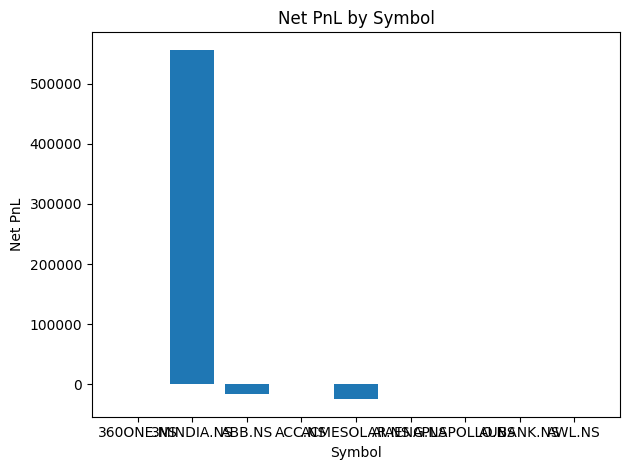

In [9]:
# ====================== OPTIONAL: SIMPLE PLOT ======================
import matplotlib.pyplot as plt

if 'summary_df' in globals() and not summary_df.empty:
    fig = plt.figure()
    plt.bar(summary_df["symbol"], summary_df["net_pnl"])
    plt.title("Net PnL by Symbol")
    plt.xlabel("Symbol")
    plt.ylabel("Net PnL")
    plt.tight_layout()
    plt.show()
